# Calculate CMIP Indeces

This file 
1. calculates all the indeces for all months for all cesmFullForcingFiles.



In [13]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp



In [2]:
import xarray
import matplotlib.pyplot as plt

# 1. Calculate CESM Indeces

import warnings
warnings.filterwarnings('ignore')

For each experiment in historical, calculate indices

In [40]:
experimentSet=['piControl', 'historical', 'past1000', 
    'rcp85']
modelSet=[
    #'bcc-csm1-1',
    #'CCSM4',
    #'CSIRO-Mk3L-1-2', #waiting download (PMIP)
    'FGOALS-gl', #waiting download
    #'FGOALS-s2',
    #'GISS-E2-R',
    #'HadCM3',
    #'IPSL-CM5A-LR', (Done)
    #'MIROC-ESM', Ts still downloading
    #'MPI-ESM-P',
    #'MRI-CGCM3'
] #_model.past1000

In [41]:
for model in modelSet:

    print(model)
    
    fxDs = fh.loadModelData(model, 'areacella_fx', '') #is the resolution the same in all th experiments?
    #SST
    tsDs = fh.loadModelData(model, 'ts', 'piControl')
    controlDs=xarray.merge([tsDs.ts, fxDs.areacella])
    controlDs=controlDs.assign_attrs({'project_id':'CMIP5'})
    
    sstClimat=sst.calculateClimatology(controlDs)
    
    pslControlDs=fh.loadModelData(model, 'psl', 'piControl')
    pslClimat=psl.calculateClimatology(pslControlDs)
    
    for experiment in experimentSet: 
        print(experiment)
        tsDs = fh.loadModelData(model, 'ts', experiment)
        sstDs = xarray.merge([tsDs.ts, fxDs.areacella])
        sstDs=sstDs.assign_attrs({'project_id':'CMIP5'})

        sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)

        pslDs = fh.loadModelData(model, 'psl', experiment)
        pslIndex, junk = psl.calculateSamIndex(pslDs, pslClimat)
        indeces = xarray.merge([pslIndex, sstIndex])
        indeces.assign_attrs(climatology='full length of pi Control')
        print(indeces)
        tp.averageForTimePeriod(indeces).to_netcdf('results/cmipWarmSeasIndeces/'+model+'_'+experiment + '.nc')



    

FGOALS-s2
/Volumes/Untitled/CMIP5-PMIP3/CMIP5/areacella_fx/
Files imported: 
 ['/Volumes/Untitled/CMIP5-PMIP3/CMIP5/areacella_fx/areacella_fx_FGOALS-s2_piControl_r0i0p0.nc']
/Volumes/Untitled/CMIP5-PMIP3/CMIP5/ts/


OSError: Files (filter term: ts.+?FGOALS-s2_piControl.*?\.nc ) not found, possibly test name is wrong

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [29]:
for experiment in experimentSet: 
    print(experiment)
    timePIndeces=list()

    for model in modelSet:
        print(model)
        indecesDs = xarray.open_dataset('results/cmipWarmSeasIndeces/' + model +'_'+ experiment + '.nc')

        timePIndeces.append(indecesDs)

    results=xarray.concat(timePIndeces, 'model')

    results['model']=modelSet

    results=results.assign_attrs({'experiment':experiment,**indecesDs.attrs,**_index.monthsOfInterest})

    results.to_netcdf('results/cmip5'+experiment+'TradIndeces.nc')

piControl
IPSL-CM5A-LR
historical
IPSL-CM5A-LR
past1000
IPSL-CM5A-LR
rcp85
IPSL-CM5A-LR


In [30]:
results

<xarray.Dataset>
Dimensions:          (model: 1, year: 294)
Coordinates:
  * year             (year) int64 2006 2007 2008 2009 ... 2296 2297 2298 2299
  * model            (model) <U12 'IPSL-CM5A-LR'
Data variables:
    nino34NoDetrend  (model, year) float32 0.4606 1.621 1.808 ... 11.44 10.76
    nino34           (model, year) float32 -0.6731 0.3564 ... -0.5114 -0.9719
    eastIO           (model, year) float32 0.1437 0.3413 ... -1.701 -1.266
    nino4            (model, year) float32 -0.6309 0.2667 ... -0.9333 -1.194
    sam              (model, year) float32 2.125 0.3875 -1.386 ... 4.961 4.037
    eastIONoDetrend  (model, year) float32 1.288 1.539 1.621 ... 10.5 10.43 10.6
    nino4NoDetrend   (model, year) float32 0.5028 1.531 1.775 ... 11.02 10.54
    dmi              (model, year) float32 -0.2853 -0.5763 ... 0.9119 0.7353
Attributes: (12/13)
    experiment:       rcp85
    nino34NoDetrend:  [7, 15]
    nino4NoDetrend:   [7, 15]
    eastIONoDetrend:  [7, 12]
    dmi:              [7, 12]
    nino34:           [7, 15]
    ...               ...
    eastIO:           [7, 12]
    sam:              [10, 15]
    lat1:             [10, 15]
    lat2:             [10, 15]
    precAnom:         [10, 15]
    tsAnom:           [10, 15]

Some sanity checks to see if it looks ok:


In [36]:
results=xarray.open_dataset('results/cmip5piControlTradIndeces.nc')

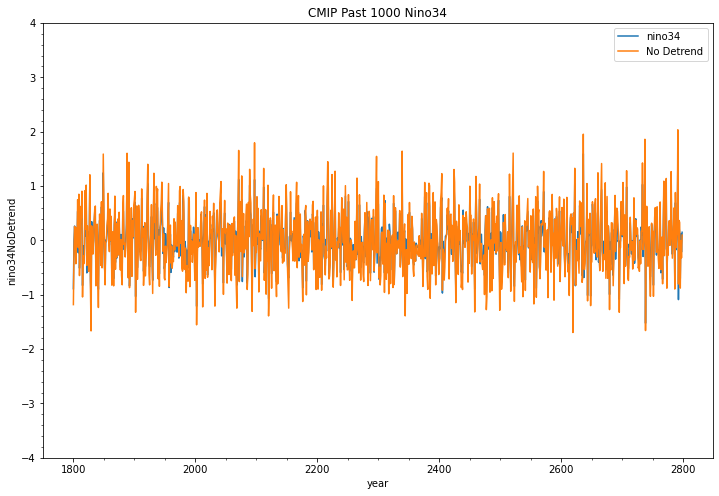

In [37]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

results.nino34.plot(label='nino34')
results.nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title("CMIP Past 1000 Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [ ]:
# A multi-experiment mean?

mean = results.sam.mean(dim='experiment')
std = results.sam.std(dim='experiment')

In [ ]:
plt.figure()
mean.plot()
std.plot()

In [ ]:
# why limit yourself to one index?

mean = results.mean(dim='experiment')
std = results.std(dim='experiment')

In [ ]:
std

# 2. Calculate Compound Years for CESM

In [ ]:
# Here is the data
indecesDs = xarray.open_dataset('results/cmip'+experiment+'TradIndeces.nc')

indecesDs.experiment.values

In [ ]:
indecesDs

# Define a criteria to determine events

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [ ]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDs.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaDa= xarray.merge(
    (stdDa[['nino34','dmi']], stdDa['sam']/2)
)

# Calculate the compounding years and plot an example

In [ ]:
%run utils/compound.ipynb



firePos, fireNeg = applyCriteria(indecesDs, criteriaDa)

firePos=compound(firePos)

fireNeg=compound(fireNeg)

firePos.to_netcdf('results/cmip'+experiment+'FirePos.nc')

fireNeg.to_netcdf('results/cmip'+experiment+'FireNeg.nc')

In [ ]:
firePos

In [ ]:
expToPlot = 'LME.002'

toPlot=3*firePos.all3.sel(experiment=expToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos[iPair].sel(experiment=expToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')